In [4]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 45.0 MB/s eta 0:00:00


The code downloads historical stock data for the ticker using the yfinance library. It then cleans the data by flattening the DataFrame structure and adding the ticker symbol as a column.

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from arch import arch_model

# Define a ticker and a date range for your data
ticker = 'QQQ'
start_date = '2022-01-01'
end_date = '2025-08-09'

# Download historical data from Yahoo Finance for a single ticker.
# This will result in a DataFrame with 'Date' as a simple index.
data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)

# Use reset_index() to convert the 'Date' index into a column.
data = data.reset_index()

# Now, to get a new DataFrame with just the 'Price' level, we can use droplevel()
# This removes the 'Ticker' level from the columns, leaving only the 'Price' level.
data = data.droplevel(level='Ticker', axis=1)

# Now, add the 'Ticker' column at position 1 (right after the 'Date' column).
data.insert(1, 'Ticker', ticker)

# The DataFrame is now a flat table with no MultiIndex.
display(data)

[*********************100%***********************]  1 of 1 completed


Price,Date,Ticker,Close,High,Low,Open,Volume
0,2022-01-03,QQQ,392.638702,392.892860,387.946756,390.067895,40575900
1,2022-01-04,QQQ,387.545990,393.225212,384.437575,393.186104,58027200
2,2022-01-05,QQQ,375.640167,386.979073,375.386010,385.854934,75739800
3,2022-01-06,QQQ,375.376251,378.631314,371.573825,373.812289,70814300
4,2022-01-07,QQQ,371.309875,377.077099,369.530864,375.386028,72652300
...,...,...,...,...,...,...,...
898,2025-08-04,QQQ,564.099976,564.320007,558.950012,559.049988,47669800
899,2025-08-05,QQQ,560.270020,566.559998,559.729980,565.390015,48666600
900,2025-08-06,QQQ,567.320007,567.760010,560.630005,561.109985,41823700
901,2025-08-07,QQQ,569.239990,573.320007,565.109985,571.669983,44463000


The cell calculates daily returns, absolute returns, and squared returns from a DataFrame of price data. It then removes the first row, which contains a null value, to prepare the data for time-series analysis.

In [6]:
df_return = pd.DataFrame(data)

# Calculate the return using the pct_change() method
# This calculates (current - prior) / prior
df_return['return'] = df_return['Close'].pct_change()

# Remove rows with empty return values (the first row)
df_return = df_return.dropna(subset=['return'])

# Calculate absolute value of the return and add the column to the df_return DataFrame
df_return['abs_return'] = np.abs(df_return['return'])

# Calculate Squared Returns and add the column to the df_return DataFrame
df_return['squared_return'] = df_return['return']**2

# Print the resulting DataFrame
display(df_return)

Price,Date,Ticker,Close,High,Low,Open,Volume,return,abs_return,squared_return
1,2022-01-04,QQQ,387.545990,393.225212,384.437575,393.186104,58027200,-0.012970,0.012970,1.682333e-04
2,2022-01-05,QQQ,375.640167,386.979073,375.386010,385.854934,75739800,-0.030721,0.030721,9.437834e-04
3,2022-01-06,QQQ,375.376251,378.631314,371.573825,373.812289,70814300,-0.000703,0.000703,4.936140e-07
4,2022-01-07,QQQ,371.309875,377.077099,369.530864,375.386028,72652300,-0.010833,0.010833,1.173495e-04
5,2022-01-10,QQQ,371.554230,372.072329,360.997335,366.383322,91770500,0.000658,0.000658,4.330787e-07
...,...,...,...,...,...,...,...,...,...,...
898,2025-08-04,QQQ,564.099976,564.320007,558.950012,559.049988,47669800,0.018452,0.018452,3.404614e-04
899,2025-08-05,QQQ,560.270020,566.559998,559.729980,565.390015,48666600,-0.006789,0.006789,4.609729e-05
900,2025-08-06,QQQ,567.320007,567.760010,560.630005,561.109985,41823700,0.012583,0.012583,1.583368e-04
901,2025-08-07,QQQ,569.239990,573.320007,565.109985,571.669983,44463000,0.003384,0.003384,1.145351e-05


In [67]:
# Calculate the total number of rows after removing empty values
total_rows = len(df_return)

# Calculate the total number of rows where abs(return) > 0.01
high_return_rows = df_return[np.abs(df_return['return']) > 0.01]
total_high_returns = len(high_return_rows)

# Calculate the ratio of total_high_returns to total_rows
ratio = total_high_returns / total_rows

print("--- Results ---")
print(f"Total number of rows after removing empty return values: {total_rows}")
print(f"Total number of rows where abs(return) > 0.01: {total_high_returns}")
print(f"Ratio of high returns to total rows: {ratio:.2f}")

--- Results ---
Total number of rows after removing empty return values: 895
Total number of rows where abs(return) > 0.01: 394
Ratio of high returns to total rows: 0.44


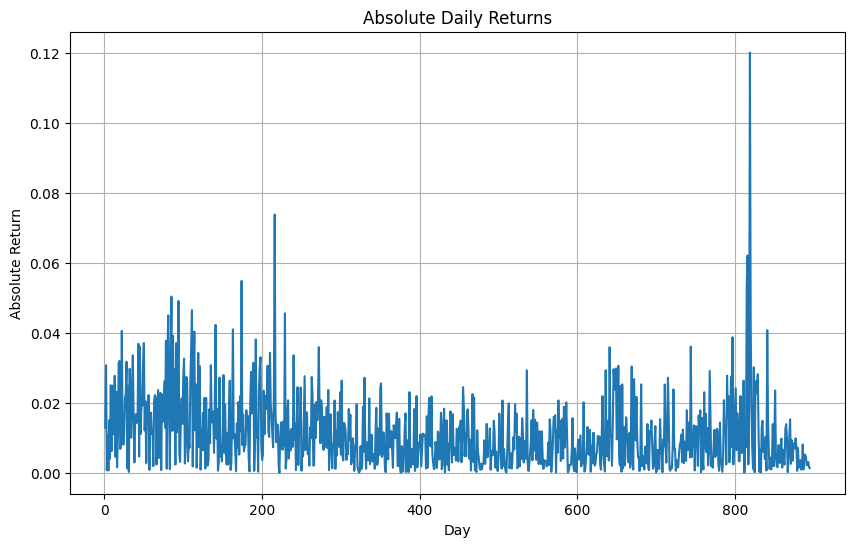

In [68]:
# Create the graph of abs(return) with the corrected syntax
# Use the plot method directly on the pandas Series for convenience
df_return['abs_return'].plot(figsize=(10, 6))

plt.title('Absolute Daily Returns')
plt.xlabel('Day')
plt.ylabel('Absolute Return')
plt.grid(True)

In [69]:
# 1. Define the event: abs(return) > 0.01
high_returns = df_return['abs_return'] > 0.01

# 2. Get the prior day's high return values using .shift()
prior_high_returns = high_returns.shift(1)

# 3. Calculate the number of days where both today's and yesterday's returns were high
# This is the count for P(A and B)
both_high = high_returns & prior_high_returns
count_both_high = both_high.sum()

# 4. Calculate the number of days where the prior day's return was high
# This is the count for P(B)
count_prior_high = prior_high_returns.sum()

# 5. Calculate the conditional probability P(A|B) = P(A and B) / P(B)
if count_prior_high > 0:
    conditional_probability = count_both_high / count_prior_high
else:
    conditional_probability = 0

print(f"Total number of days with abs(return) > 0.01: {high_returns.sum()}")
print(f"Total number of days where abs(return) > 0.01 on the prior day: {count_prior_high}")
print(f"Total number of days where abs(return) > 0.01 on both the current and prior day: {count_both_high}")
print(f"\nThe conditional probability is: {conditional_probability:.2f}")

Total number of days with abs(return) > 0.01: 394
Total number of days where abs(return) > 0.01 on the prior day: 394
Total number of days where abs(return) > 0.01 on both the current and prior day: 181

The conditional probability is: 0.46


In [70]:
# Calculate Autocorrelation for a specific lag (e.g., lag 1)
# A positive value suggests that a large squared return is followed by another large squared return, which is an indication of volatility clustering.
autocorr_lag1 = df_return['squared_return'].autocorr(lag=1)

# --- Logic to calculate the confidence interval ---
# N is the number of data points
N = len(df_return)

# The 95% confidence interval is approximately +/- 2/sqrt(N)
conf_interval = 2 / np.sqrt(N)

print("--- Autocorrelation of Squared Returns ---")
print(f"Autocorrelation at lag 1: {autocorr_lag1:.4f}")
print(f"95% Confidence Interval: +/- {conf_interval:.4f}")

# Check for statistical significance
if np.abs(autocorr_lag1) > conf_interval:
    print("\nInterpretation: The autocorrelation is statistically significant, indicating volatility clustering is present.")
else:
    print("\nInterpretation: The autocorrelation is not statistically significant, suggesting no strong evidence of volatility clustering.")

--- Autocorrelation of Squared Returns ---
Autocorrelation at lag 1: 0.1210
95% Confidence Interval: +/- 0.0669

Interpretation: The autocorrelation is statistically significant, indicating volatility clustering is present.


In [71]:
# Rescale the data to a better range (e.g., multiply by 100)
rescale_factor = 100
scaled_returns = df_return['return'] * rescale_factor

# Fit a GARCH(1,1) model to the scaled returns
# This will prevent the DataScaleWarning
am = arch_model(scaled_returns, vol='Garch', p=1, q=1)
res = am.fit(disp='off')

# Forecast the next day's conditional variance
forecasts = res.forecast(horizon=1)
next_day_variance = forecasts.variance.iloc[-1]

# The forecast is on the scaled data, so we must unscale it
estimated_abs_return = np.sqrt(next_day_variance.iloc[0]) / rescale_factor

print(f"\nEstimated conditional variance for the next day: {next_day_variance.iloc[0]:.6f}")
print(f"Estimated abs_return for the next day: {estimated_abs_return:.4f}")


Estimated conditional variance for the next day: 0.438139
Estimated abs_return for the next day: 0.0066


The code below is a script for evaluating a GARCH model's forecasting ability using a rolling forecast.

Here's a brief breakdown of what it does:

1. Data Preparation and Rescaling <br>
The code first creates a sample time series of returns that mimics real-world data with volatility clustering. It then rescales this data by multiplying it by a factor of 100. This is done to address a common numerical issue in GARCH models, making the fitting process more stable and accurate.

2. Rolling Forecast Loop <br>
This is the core of the script. It sets up a loop to simulate a real-time forecasting scenario.

In each iteration, the GARCH model is re-fitted to all available historical data up to that point.

A one-day-ahead forecast is made based on the newly fitted model.

The forecast is then unscaled (divided by 100) and stored.

This process provides a series of realistic daily predictions for the out-of-sample period.

3. Error Calculation and Comparison <br>
Finally, the script compares the stored predictions with the actual observed abs_return values. It calculates the Mean Absolute Error (MAE), which provides a single, easy-to-interpret number that tells you the average daily error of your forecast. The lower the MAE, the better the model's predictive performance.

In [72]:
# Rescale the data to prevent the DataScaleWarning
rescale_factor = 100
scaled_returns = df_return['return'] * rescale_factor

# Set up the rolling forecast
# We'll use the last 50 days to test our predictions
out_of_sample_period = 50
predictions = []
actuals = scaled_returns[-out_of_sample_period:].abs().values

# Perform the rolling forecast
# The loop re-fits the model each day and makes a one-day-ahead prediction
for i in range(out_of_sample_period):
    train_data = scaled_returns[:-(out_of_sample_period - i)]
    am = arch_model(train_data, vol='Garch', p=1, q=1)
    res = am.fit(disp='off')

    # Get the one-day-ahead variance forecast and unscale it
    forecast = res.forecast(horizon=1)
    predicted_variance = forecast.variance.iloc[-1].iloc[0]
    predicted_abs_return = np.sqrt(predicted_variance)

    predictions.append(predicted_abs_return / rescale_factor)

# Create a DataFrame to compare predictions and actuals
df_results = pd.DataFrame({
    'Actual_abs_Return': np.abs(df_return['return'][-out_of_sample_period:]),
    'Predicted_abs_Return': predictions
})

# Calculate the Mean Absolute Error (MAE)
mae = np.mean(np.abs(df_results['Actual_abs_Return'] - df_results['Predicted_abs_Return']))

print("\n--- GARCH Rolling Forecast Results ---")
print(f"Mean Absolute Error (MAE) for the last {out_of_sample_period} days: {mae:.6f}")
print("\nDataFrame with Actual vs. Predicted values:")
print(df_results.head())

# To display the last 10 rows
print(df_results.tail(10))


--- GARCH Rolling Forecast Results ---
Mean Absolute Error (MAE) for the last 50 days: 0.006300

DataFrame with Actual vs. Predicted values:
     Actual_abs_Return  Predicted_abs_Return
846           0.000959              0.019500
847           0.003333              0.018530
848           0.013897              0.017615
849           0.001871              0.017344
850           0.009261              0.016424
     Actual_abs_Return  Predicted_abs_Return
886           0.008093              0.008045
887           0.000961              0.008125
888           0.005185              0.007897
889           0.005176              0.007766
890           0.004561              0.007816
891           0.002128              0.007655
892           0.002407              0.007420
893           0.003125              0.007198
894           0.001549              0.007002
895           0.001340              0.006844


In [10]:
# --- Rolling Average and MAE Calculation ---

# 1. Calculate the rolling average for a 3-day window using the previous days only
df_return['rolling_avg_3d'] = df_return['abs_return'].rolling(window=3).mean().shift(1)

# 2. Calculate the rolling average for a 5-day window using the previous days only
df_return['rolling_avg_5d'] = df_return['abs_return'].rolling(window=5).mean().shift(1)

# Drop rows with NaN values (the first few rows) to allow for MAE calculation
df_clean = df_return.dropna()

# 3. Calculate the MAE for the entire dataset
mae_3d_total = np.mean(np.abs(df_clean['abs_return'] - df_clean['rolling_avg_3d']))
mae_5d_total = np.mean(np.abs(df_clean['abs_return'] - df_clean['rolling_avg_5d']))

# 4. Calculate the MAE for the last 50 days (to compare with GARCH results)
out_of_sample_period = 50
df_test = df_clean.tail(out_of_sample_period)
mae_3d_last_50 = np.mean(np.abs(df_test['abs_return'] - df_test['rolling_avg_3d']))
mae_5d_last_50 = np.mean(np.abs(df_test['abs_return'] - df_test['rolling_avg_5d']))

print("--- Rolling Average Forecasts ---")
print(f"Mean Absolute Error (MAE) for 3-day rolling average (entire dataset): {mae_3d_total:.6f}")
print(f"Mean Absolute Error (MAE) for 5-day rolling average (entire dataset): {mae_5d_total:.6f}")
print("---")
print(f"Mean Absolute Error (MAE) for 3-day rolling average (last 50 days): {mae_3d_last_50:.6f}")
print(f"Mean Absolute Error (MAE) for 5-day rolling average (last 50 days): {mae_5d_last_50:.6f}")

print("\nSample of the DataFrame with rolling averages (last 50 days):")
print(df_test.tail(10))

--- Rolling Average Forecasts ---
Mean Absolute Error (MAE) for 3-day rolling average (entire dataset): 0.008310
Mean Absolute Error (MAE) for 5-day rolling average (entire dataset): 0.007766
---
Mean Absolute Error (MAE) for 3-day rolling average (last 50 days): 0.003994
Mean Absolute Error (MAE) for 5-day rolling average (last 50 days): 0.003752

Sample of the DataFrame with rolling averages (last 50 days):
Price       Date Ticker       Close        High         Low        Open  \
893   2025-07-28    QQQ  568.140015  569.039978  566.869995  567.739990   
894   2025-07-29    QQQ  567.260010  572.109985  566.530029  570.760010   
895   2025-07-30    QQQ  568.020020  570.619995  565.049988  568.179993   
896   2025-07-31    QQQ  565.010010  574.630005  563.869995  574.539978   
897   2025-08-01    QQQ  553.880005  559.020020  551.679993  558.830017   
898   2025-08-04    QQQ  564.099976  564.320007  558.950012  559.049988   
899   2025-08-05    QQQ  560.270020  566.559998  559.729980  5